## Correcting For Distortion

![Distorted and Undistorted Images](orig-and-undist.png)

Here, you'll get a chance to try camera calibration and distortion correction for yourself!  

There are two main steps to this process: use chessboard images to obtain image points and object points, and then use the OpenCV functions `cv2.calibrateCamera()` and `cv2.undistort()` to compute the calibration and undistortion.  

Unfortunately, we can't perform the extraction of object points and image points in the browser quiz editor, so we provide these for you in the quiz below.  

Try computing the calibration and undistortion in the exercise below, and if you want to play with extracting object points and image points yourself, fork the Jupyter notebook and images in [this repository](https://github.com/udacity/CarND-Camera-Calibration). You can also download the [distortion pickle file](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/wide_dist_pickle.p) and [test image](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/files/Advanced_Lane_Finding_Images/correct_for_distortion/test_image.png) used in the below quiz if you'd like to run the below code on your own machine.

If you run into any *errors* as you run your code, please refer to the **Examples of Useful Code** section in the previous video and make sure that your code syntax matches up!

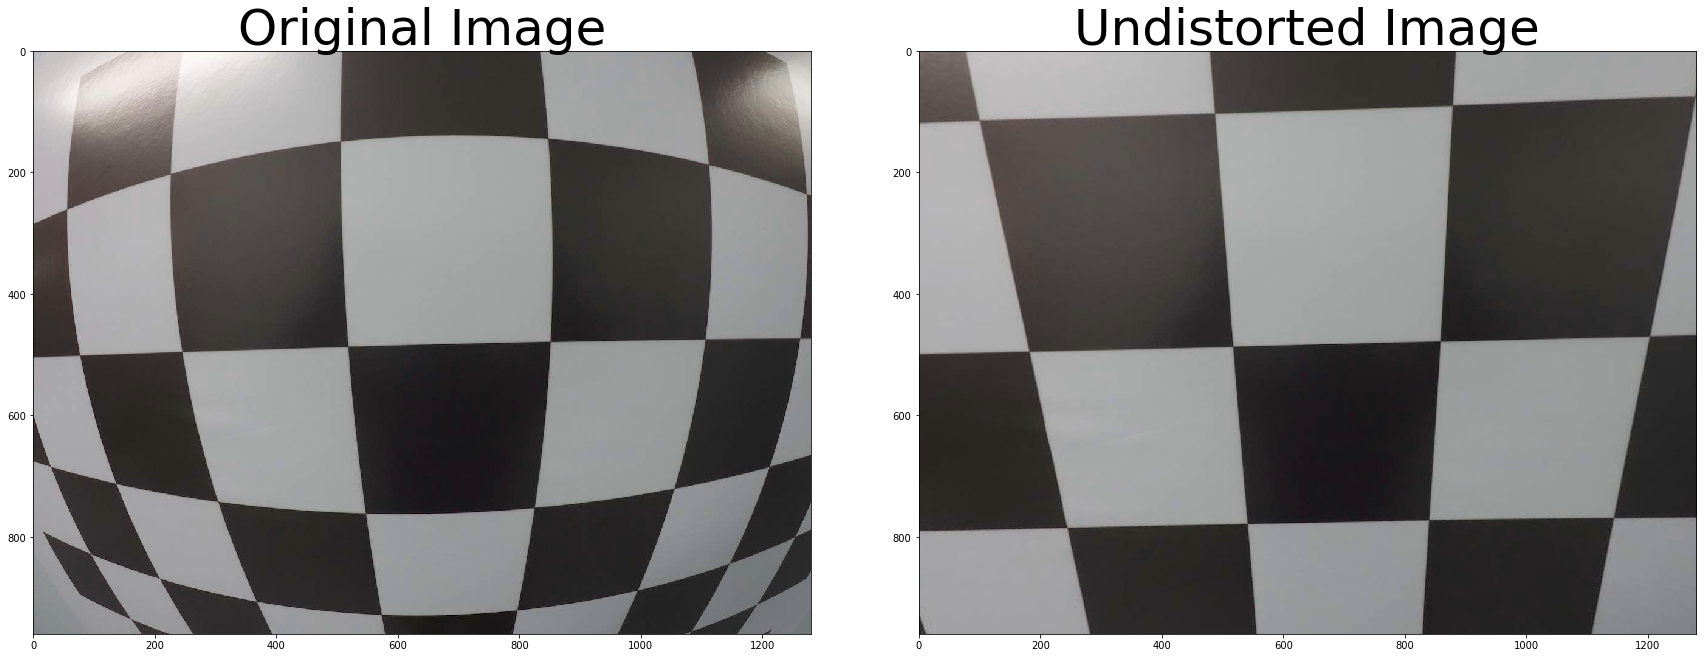

In [1]:
%matplotlib inline

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('test_image.png')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

You can test your code by running the cell below when you feel satisfied with your results.

In [2]:
import test_calibration

test_calibration.test(undistorted)

'Correct! Nice work.'

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        write_name = './output/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Text(0.5, 1.0, 'Undistorted Image')

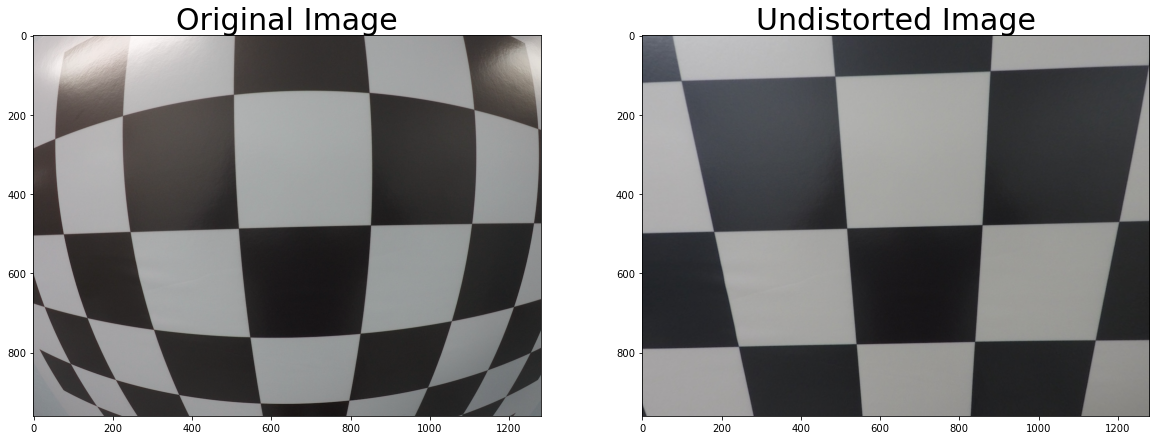

In [22]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


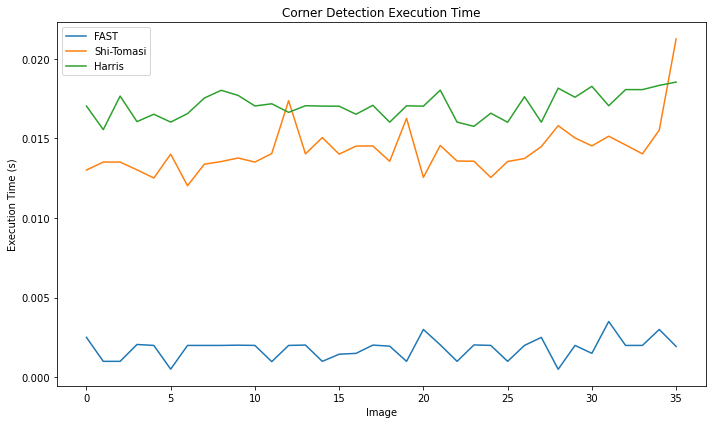

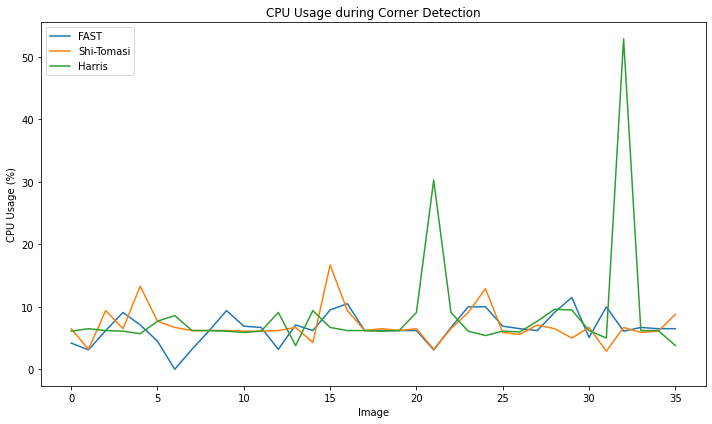

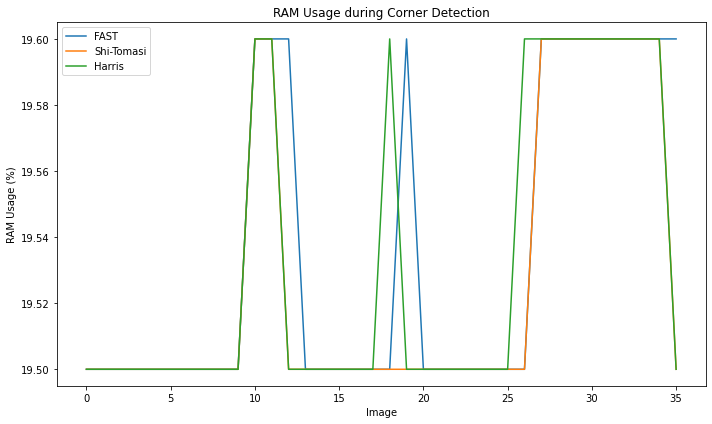

In [23]:
import numpy as np
import cv2
import glob
import time
import psutil
import matplotlib.pyplot as plt

objp = np.zeros((6*8, 3), np.float32)
objp[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)

objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

images = glob.glob('calibration_wide/GO*.jpg')

def detect_corners_fast(gray: np.ndarray) -> tuple[bool, np.ndarray]:
    """Detect corners using FAST algorithm."""
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(gray, None)
    corners = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)
    ret = len(corners) == 48
    return ret, corners

def detect_corners_shi_tomasi(gray: np.ndarray) -> tuple[bool, np.ndarray]:
    """Detect corners using Shi-Tomasi algorithm."""
    corners = cv2.goodFeaturesToTrack(gray, 48, 0.01, 10)
    ret = corners is not None and len(corners) == 48
    return ret, corners

def detect_corners_harris(gray: np.ndarray) -> tuple[bool, np.ndarray]:
    """Detect corners using Harris algorithm."""
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)
    ret = len(corners) == 48
    return ret, corners

times_fast = []
times_shi_tomasi = []
times_harris = []
cpu_usage_fast = []
cpu_usage_shi_tomasi = []
cpu_usage_harris = []
ram_usage_fast = []
ram_usage_shi_tomasi = []
ram_usage_harris = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    start_time = time.time()
    ret_fast, corners_fast = detect_corners_fast(gray)
    elapsed_time = time.time() - start_time
    times_fast.append(elapsed_time)
    cpu_usage_fast.append(psutil.cpu_percent())
    ram_usage_fast.append(psutil.virtual_memory().percent)

    start_time = time.time()
    ret_shi_tomasi, corners_shi_tomasi = detect_corners_shi_tomasi(gray)
    elapsed_time = time.time() - start_time
    times_shi_tomasi.append(elapsed_time)
    cpu_usage_shi_tomasi.append(psutil.cpu_percent())
    ram_usage_shi_tomasi.append(psutil.virtual_memory().percent)

    start_time = time.time()
    ret_harris, corners_harris = detect_corners_harris(gray)
    elapsed_time = time.time() - start_time
    times_harris.append(elapsed_time)
    cpu_usage_harris.append(psutil.cpu_percent())
    ram_usage_harris.append(psutil.virtual_memory().percent)

    if ret_fast or ret_shi_tomasi or ret_harris:
        objpoints.append(objp)
        if ret_fast:
            imgpoints.append(corners_fast)
        elif ret_shi_tomasi:
            imgpoints.append(corners_shi_tomasi)
        elif ret_harris:
            imgpoints.append(corners_harris)

        cv2.drawChessboardCorners(img, (8, 6), imgpoints[-1], True)
        write_name = './output/corners_found_' + fname.split('/')[-1]
        cv2.imwrite(write_name, img)

plt.figure(figsize=(10, 6))
plt.plot(times_fast, label='FAST')
plt.plot(times_shi_tomasi, label='Shi-Tomasi')
plt.plot(times_harris, label='Harris')
plt.xlabel('Image')
plt.ylabel('Execution Time (s)')
plt.title('Corner Detection Execution Time')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cpu_usage_fast, label='FAST')
plt.plot(cpu_usage_shi_tomasi, label='Shi-Tomasi')
plt.plot(cpu_usage_harris, label='Harris')
plt.xlabel('Image')
plt.ylabel('CPU Usage (%)')
plt.title('CPU Usage during Corner Detection')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ram_usage_fast, label='FAST')
plt.plot(ram_usage_shi_tomasi, label='Shi-Tomasi')
plt.plot(ram_usage_harris, label='Harris')
plt.xlabel('Image')
plt.ylabel('RAM Usage (%)')
plt.title('RAM Usage during Corner Detection')
plt.legend()
plt.tight_layout()
plt.show()
